In [6]:
import sys
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy.special import factorial
import seaborn as sns
import pandas as pd
import re
import statistics
from scipy import stats
import math

font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

# from other notebooks
cutoffA_vTR = 3.24704700060297
cutoffR_vTR = 0.6920252964595188
cutoffA_HHV = 1.0846347878236864
cutoffR_HHV = 0.6987727639587654

### HHV proteins tiled by virus

#### Barplot featured in Fig. S3A

    Virus  Count
2     EBV     93
3    HCMV    238
4   HHV6A    103
5   HHV6B    102
6    HHV7     63
7    HSV1     85
8    HSV2     79
9    KSHV     85
10  SuHV1     37
11    VZV     70


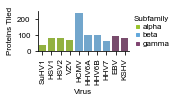

In [40]:
from pandas.api.types import CategoricalDtype

u90 = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/uniref_reviewed_HHV+SuHV.csv')
u90 = u90.rename(columns={'Cluster ID':'UniProt ID'})
dfmap = pd.read_csv('../Supplemental Tables - CSV/uID_protein_virus_mapping_HHV_expanded.csv')
u90 = pd.merge(u90, dfmap, on='UniProt ID', how='left')
u90['Count'] = 1
u90 = u90[['Virus', 'Count']].groupby('Virus', axis=0).sum().reset_index()
u90 = u90[~u90['Virus'].str.contains('CeHV')]
print(u90)

vir2sub = {'HSV1':'alpha', 'HSV2':'alpha', 'VZV':'alpha', 'SuHV1':'alpha',
           'HCMV':'beta', 'HHV6A':'beta', 'HHV6B':'beta', 'HHV7':'beta',
           'EBV':'gamma', 'KSHV':'gamma'}
u90['Subfamily'] = u90['Virus'].map(vir2sub)
u90['Virus'] = u90['Virus'].astype(CategoricalDtype(categories=['SuHV1', 'HSV1', 'HSV2', 'VZV', 'HCMV',
                                                                'HHV6A', 'HHV6B', 'HHV7','EBV', 'KSHV'], ordered=True))
u90 = u90.sort_values(by='Virus')

colors = ['#9AC42D']*4 + ['#63A8DB']*4 + ['#804571']*2
colors2 = ['#9AC42D', '#63A8DB', '#804571']
sf_pal = sns.color_palette(colors)
plt.figure(figsize=(2.5,1.4))
sns.barplot(data=u90, x='Virus', y='Count', palette=sf_pal)
plt.yticks(ticks=[0, 100, 200])
plt.xticks(rotation=90)
plt.ylabel('Proteins Tiled')
alpha = matplotlib.lines.Line2D([0], [0], marker='s', lw=0, color=colors2[0], label='alpha')
beta = matplotlib.lines.Line2D([0], [0], marker='s', lw=0, color=colors2[1], label='beta')
gamma = matplotlib.lines.Line2D([0], [0], marker='s', lw=0, color=colors2[2], label='gamma')
plt.legend(handles=[alpha, beta, gamma], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='Subfamily',
           labelspacing=0.2, markerscale=0.5, handletextpad=0.2, borderpad=0, borderaxespad=0.5, handlelength=1)
sns.despine()
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S3/HHV_screen_proteins_tiled_by_virus.png', dpi=1200)

### Magnetic separation for HHV activation screen

#### Flow distributions featured in Fig. S3B & S3C

In [2]:
df = pd.read_csv('../Flow Single-Cell Data - CSV/HHV_primary_Screens_magsep_single-cell.csv')
df = df[(df['P1']==True) & (df['P2']==True)]
df = df.rename(columns={'Citrine':'Citrine_Act'})
df['Citrine_Rep'] = np.where(df['Citrine-A']>1e7, True, False)
df = df[df['Fraction']!='wash']
df['Fraction'] = pd.Categorical(df['Fraction'], categories=['pre-magsep', 'unbound', 'bound'])
aggdf = df.groupby(by=['Reporter', 'Fraction'], as_index=False).mean().sort_values(by=['Reporter', 'Fraction'])

aggdf

,Reporter,Fraction,Citrine-A,FSC 488/10-A,FSC 488/10-H,SSC 488/10-A,mCherry-A,P1,P2,mCherry,Citrine_Act,Citrine_Rep
0,DY032,pre-magsep,1.968361e+06,1.010879e+09,7.971203e+08,3.699215e+08,8.660235e+07,1.0,1.0,0.946253,0.026269,0.004402
1,DY032,unbound,7.599170e+05,1.321352e+09,1.048310e+09,3.732983e+08,7.977867e+07,1.0,1.0,0.941835,0.004202,0.000186
2,DY032,bound,2.573614e+07,1.036569e+09,7.111715e+08,1.398560e+09,7.749006e+07,1.0,1.0,0.989733,0.747433,0.521561
3,JT039,pre-magsep,9.719899e+07,1.212391e+09,8.821790e+08,1.569425e+09,1.333310e+08,1.0,1.0,0.988853,0.926922,0.902661
4,JT039,unbound,1.760478e+07,1.430094e+09,1.136675e+09,4.752881e+08,1.191037e+08,1.0,1.0,0.923505,0.392989,0.293685
5,JT039,bound,1.043897e+08,1.178348e+09,8.951990e+08,1.305901e+09,1.233750e+08,1.0,1.0,0.986248,0.996275,0.986340


In [23]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

tempdf = df.copy()
tempdf['mCitrine'] = np.log10(tempdf['Citrine-A'])

def plot_magsep(data_df, agg_df, screentype):
    if screentype == 'Activation':
        reporter = 'DY032'
        citrine = 'Citrine_Act'
        color = '#F3CE48'
        cutoff = 3e6
        upperylim = 4
    elif screentype == 'Repression':
        reporter = 'JT039'
        citrine = 'Citrine_Rep'
        color = '#23BEDB'
        cutoff = 1e7
        upperylim = 2.5
    
    ON = list(agg_df[agg_df['Reporter']==reporter][citrine])
    ON = [round(on*100, 1) for on in ON]
    OFF = [str(round(100-on, 1)) + '%' for on in ON]
    ON = [str(on) + '%' for on in ON]
    
    pal = sns.color_palette([color, color])
    g = sns.FacetGrid(data=data_df[data_df['Reporter']==reporter],
                      col='Fraction', hue='Replicate', palette=pal,
                      aspect=0.92, height=1.35)
    g.map(sns.kdeplot, 'mCitrine', fill=True, bw_adjust=1)
    g.set_titles(template='{col_name}')
    
    plt.xlim([4.5,9.5])
    plt.ylim([0,upperylim])
    plt.xticks([5, 6, 7, 8, 9], ['10$^5$', '10$^6$', '10$^7$', '10$^8$', '10$^9$'])
    for i, ax, on, off in zip(range(6), g.axes.flat, ON, OFF):
        ax.text(0.05, 0.95, off, transform=ax.transAxes, ha='left', va='top')
        ax.text(0.95, 0.95, on, transform=ax.transAxes, ha='right', va='top')
        ax.axvline(x=np.log10(cutoff), ls=':', color='#333333', lw=1)
#         ax.grid(False)
    
    plt.savefig('../Individual Figure Panels/Figure S3/HHV_primary_Screens_%s_magsep_kdeplot.png' % screentype, dpi=1200)
    plt.close()
    
    
plot_magsep(tempdf, aggdf, 'Activation')
plot_magsep(tempdf, aggdf, 'Repression')

print('Complete')

Complete


### Correlation of HHV screen scores and validation % ON or OFF

In [51]:
df = pd.read_csv('../Flow Single-Cell Data - CSV/HHV_Screen_validations_endpoint_single-cell.csv')
df = df[(df['P1']==True) & (df['P2']==True) & (df['mCherry']==True)]
df = df.rename(columns={'Citrine':'Citrine_Act'})
df['Citrine_Rep'] = np.where(df['Citrine-A']>1e7, True, False)
df.loc[df['Protein'].isna(), 'Protein'] = 'empty' 

aggdf = df.groupby(by=['Reporter', 'Condition', 'Construct', 'Protein', 'Replicate', 'Time'], as_index=False).mean()
aggdf

,Reporter,Condition,Construct,Protein,Replicate,Time,Citrine-A,FSC 488/10-A,FSC 488/10-H,SSC 488/10-A,mCherry-A,P1,P2,mCherry,Citrine_Act,Citrine_Rep
0,DY032,dox,CL144,Human MYBA,Rep1,2.0,1.162849e+08,1.201747e+09,9.931874e+08,3.442835e+08,1.052507e+08,1.0,1.0,1.0,0.949705,0.901215
1,DY032,dox,CL144,Human MYBA,Rep2,2.0,1.160444e+08,1.235165e+09,1.016668e+09,3.474856e+08,1.062152e+08,1.0,1.0,1.0,0.941752,0.883988
2,DY032,dox,CL303,SuHV1 ICP4,Rep1,2.0,2.006007e+08,1.121347e+09,9.420318e+08,3.516755e+08,7.868721e+07,1.0,1.0,1.0,0.979629,0.957323
3,DY032,dox,CL303,SuHV1 ICP4,Rep2,2.0,1.883596e+08,1.155564e+09,9.620311e+08,3.678149e+08,7.782683e+07,1.0,1.0,1.0,0.977665,0.956984
4,DY032,dox,CL304,HHV6B U95,Rep1,2.0,5.845759e+07,1.165530e+09,9.716896e+08,3.552639e+08,7.774243e+07,1.0,1.0,1.0,0.895160,0.802736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,JT039,nodox,JT126,empty,Rep2,5.0,8.356878e+07,1.113476e+09,9.404946e+08,4.088612e+08,1.174629e+08,1.0,1.0,1.0,0.970775,0.953513
272,JT039,nodox,JT151,Human KRAB,Rep1,0.0,1.331292e+08,1.224400e+09,1.014142e+09,4.625284e+08,1.315167e+08,1.0,1.0,1.0,0.970458,0.955888
273,JT039,nodox,JT151,Human KRAB,Rep1,5.0,7.970914e+07,1.092030e+09,9.180154e+08,4.032485e+08,9.560396e+07,1.0,1.0,1.0,0.955348,0.926125
274,JT039,nodox,JT151,Human KRAB,Rep2,0.0,1.382979e+08,1.281184e+09,1.064256e+09,4.621152e+08,1.382659e+08,1.0,1.0,1.0,0.972111,0.959528


In [52]:
constructDict = {'CL144':['Human', 'MYBA', '', ''],
                 'JT151':['Human', 'KRAB', '', ''],
                 'JT126':['', 'empty', '', '']}

data = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_ActivD2-ReprD5_detailed.csv')
key = pd.read_csv('../Flow Single-Cell Data - CSV/HHV_validations_key.csv')
key = key[['Construct', 'Tile_ID']].rename(columns={'Tile_ID':'Tile ID'})
key = pd.merge(key, data, on='Tile ID', how='left')

for i in constructDict:
    key.loc[key['Construct']==i, 'Virus Abbreviation'] = constructDict[i][0]
    key.loc[key['Construct']==i, 'Protein'] = constructDict[i][1]
    key.loc[key['Construct']==i, 'Tile Start'] = constructDict[i][2]
    key.loc[key['Construct']==i, 'Tile End'] = constructDict[i][3]
# key.loc[key['Protein']=='ORF50', 'Protein'] = 'RTA'

aggdfA = aggdf[aggdf['Reporter']=='DY032']
aggdfA = aggdfA[['Construct', 'Condition', 'Replicate', 'Citrine_Act']]
aggdfA['Citrine OFF'] = 1 - aggdfA['Citrine_Act']

# normdf = aggdfA[aggdfA['Condition']=='dox']
normdf = aggdfA.copy()
normdf['Citrine ON'] = normdf['Citrine_Act']*100
normdf = normdf.groupby(by=['Construct', 'Condition'])['Citrine ON'].agg(['mean', 'std']).reset_index()
# normdf = normdf.groupby(by=['Construct'])['Citrine ON'].agg(['mean', 'std']).reset_index()
normdf = normdf.rename(columns={'mean':'Citrine ON', 'std':'ON std'})
keyA = pd.merge(key, normdf, on='Construct', how='left') #.drop_duplicates(subset=['Tile ID', 'Screen'])

aggdfR = aggdf[aggdf['Reporter']=='JT039']
aggdfR = aggdfR[['Construct', 'Condition', 'Replicate', 'Citrine_Rep']]
aggdfR['Citrine OFF'] = 1 - aggdfR['Citrine_Rep']

# normdf = aggdfR[aggdfR['Condition']=='dox']
normdf = aggdfR.copy()
normdf['Citrine OFF'] = normdf['Citrine OFF']*100
normdf = normdf.groupby(by=['Construct', 'Condition'])['Citrine OFF'].agg(['mean', 'std']).reset_index()
# normdf = normdf.groupby(by=['Construct'])['Citrine OFF'].agg(['mean', 'std']).reset_index()
normdf = normdf.rename(columns={'mean':'Citrine OFF', 'std':'OFF std'})

keyR = pd.merge(key, normdf, on='Construct', how='left') #.drop_duplicates(subset=['Tile ID', 'Screen'])
print('Complete')

Complete


In [53]:
keyA_save = keyA[keyA['Screen']!='Repression']
keyA_save = keyA_save[['Construct', 'Tile ID', 'Virus Abbreviation', 'Protein', 'Avg', 'Standard Error', 'Condition', 'Citrine ON', 'ON std']]
keyA_save = keyA_save[~keyA_save['Citrine ON'].isna()].reset_index(drop=True)
keyA_save = keyA_save.rename(columns={'Virus Abbreviation':'Virus', 'Avg':'Screen Score Mean', 'Standard Error':'Screen Score Std Error',
                                      'Citrine ON':'Flow Cytometry %ON Mean', 'ON std':'Flow Cytometry %ON Std Dev'})
keyA_save = keyA_save.drop_duplicates()
keyA_save.to_csv('../Flow Summaries - CSV/HHV-tiling_Act_screen_validation_summary.csv', index=False)

keyR_save = keyR[keyR['Screen']!='Activation']
keyR_save = keyR_save[['Construct', 'Tile ID', 'Virus Abbreviation', 'Protein', 'Avg', 'Standard Error', 'Condition', 'Citrine OFF', 'OFF std']]
keyR_save = keyR_save[~keyR_save['Citrine OFF'].isna()].reset_index(drop=True)
keyR_save = keyR_save.rename(columns={'Virus Abbreviation':'Virus', 'Avg':'Screen Score Mean', 'Standard Error':'Screen Score Std Error',
                                      'Citrine OFF':'Flow Cytometry %OFF Mean', 'OFF std':'Flow Cytometry %OFF Std Dev'})
keyR_save = keyR_save.drop_duplicates()
keyR_save.to_csv('../Flow Summaries - CSV/HHV-tiling_Repr_screen_validation_summary.csv', index=False)
print('Complete')

Complete


#### Correlation plot featured in Fig. 2B

[96.92073446  5.70115069  0.9198081   1.06626647]
0.9693675889328063 2.7752536222287567e-14


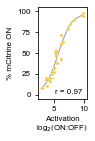

In [55]:
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
colorA = '#F3CE48' #'#E3B919'

plt.figure(figsize=(1.35,2))
plotDF = keyA[(keyA['Condition']=='dox') & (keyA['Screen']!='Repression') & (~keyA['Citrine ON'].isna()) & (~keyA['Avg'].isna())].sort_values('Avg')
plotDF = plotDF[plotDF['Duplicate']==0]

sns.scatterplot(data=plotDF, x='Avg', y='Citrine ON', color=colorA, s=10)
x = np.array(list(plotDF['Avg']))
y = np.array(list(plotDF['Citrine ON']))
xerr = list(plotDF['Standard Error'])
yerr = list(plotDF['ON std'])
for xi, yi, xe, ye in zip(list(x), list(y), xerr, yerr):
    plt.errorbar(x=xi, y=yi, xerr=xe, yerr=ye, color=colorA, lw=1)

def logistic(x, A, x0, k, off):
    return A/(1 + np.exp(-k*(x-x0)))+off
p, _ = curve_fit(logistic, x, y, p0=[10,6,1,0])
print(p)
plt.plot(x, logistic(x, *p), color='#999999', lw=1, zorder=0)

coef, p = spearmanr(x, y)
print(coef, p)
plt.annotate('r = ' + str(round(coef, 2)), xy=(9.7, 0), ha='right', va='bottom')
# plt.axvline(x=cutoffA_HHV, ls=':', lw=1, color='#333333')
plt.xlabel('Activation\nlog$_2$(ON:OFF)')
plt.ylabel('% mCitrine ON')
plt.yticks([0, 25, 50, 75, 100], [0, 25, 50, 75, 100])
plt.ylim(-5, 105)
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure 2/HHV_Act_screen-validation_correlation.png', dpi=1200)


#### Correlation plot featured in Fig. 2C

[105.77107461   2.17386321   1.05766339  -4.35079577]
0.8935064935064935 4.9461674793322084e-08


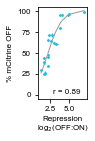

In [54]:
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
colorR = '#23BEDB'

plt.figure(figsize=(1.35,2))
plotDF = keyR[(keyR['Condition']=='dox') & (keyR['Screen']!='Activation') & (~keyR['Citrine OFF'].isna()) & (~keyR['Avg'].isna())].sort_values('Avg')
plotDF = plotDF[plotDF['Duplicate']==0]

sns.scatterplot(data=plotDF, x='Avg', y='Citrine OFF', color=colorR, s=10)
x = np.array(list(plotDF['Avg']))
y = np.array(list(plotDF['Citrine OFF']))
xerr = list(plotDF['Standard Error'])
yerr = list(plotDF['OFF std'])
for xi, yi, xe, ye in zip(list(x), list(y), xerr, yerr):
    plt.errorbar(x=xi, y=yi, xerr=xe, yerr=ye, color=colorR, lw=1)

def logistic(x, A, x0, k, off):
    return A/(1 + np.exp(-k*(x-x0)))+off
p, _ = curve_fit(logistic, x, y, p0=[100,6,1,0])
print(p)
plt.plot(x, logistic(x, *p), color='#999999', lw=1, zorder=0)

coef, p = spearmanr(x, y)
print(coef, p)
plt.annotate('r = ' + str(round(coef, 2)), xy=(6.5, 0), ha='right', va='bottom')
plt.xlabel('Repression\nlog$_2$(OFF:ON)')
plt.ylabel('% mCitrine OFF')
plt.yticks([0, 25, 50, 75, 100], [0, 25, 50, 75, 100])
plt.ylim(-5, 105)
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure 2/HHV_Rep_screen-validation_correlation.png', dpi=1200)


### HHV validation endpoint flow distributions

#### All validation flow cytometry distributions (not featured in a panel)

In [56]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

def plot_validations(df, screentype, key):
    if screentype == 'Activation':
        reporter = 'DY032'
        color = '#F3CE48'
        yvar = 'Citrine ON'
        opposite = 'Repression'
        cutoff = 3e6
    elif screentype == 'Repression':
        reporter = 'JT039'
        color = '#23BEDB'
        yvar = 'Citrine OFF'
        opposite = 'Activation'
        cutoff = 1e7
    
    df = df[df['Reporter']==reporter]
    df['mCitrine'] = np.log10(df['Citrine-A'])
    df = df.drop(columns='Protein')
    df = pd.merge(df, key[['Construct', 'Avg', 'Virus Abbreviation', 'Protein', 'Tile Start', 'Tile End', yvar, 'Screen']], how='left', on='Construct')
    df.loc[df['Avg'].isna(), 'Avg'] = -10
    df['Condition'] = pd.Categorical(df['Condition'], categories=['nodox', 'dox'], ordered=True)
    df = df.sort_values(by=['Avg', 'Condition', 'Replicate'], ascending=[False, True, True])
    df['Condition-Replicate'] = df['Condition'].astype(str) + '-' + df['Replicate']

    labeldf = df[df['Screen']!=opposite].sort_values(by=['Avg'], ascending=False)
    labeldf = labeldf[['Construct', 'Virus Abbreviation', 'Protein', 'Tile Start', 'Tile End', yvar, 'Avg']].drop_duplicates()
    labeldf['Tile Start'] = np.where(labeldf['Tile Start']=='', labeldf['Tile Start'], labeldf['Tile Start'].astype(str).str.split('.').str[0])
    labeldf['Tile End'] = np.where(labeldf['Tile End']=='', labeldf['Tile End'], labeldf['Tile End'].astype(str).str.split('.').str[0])
    labeldf['Sample'] = np.where(labeldf['Tile Start']=='', labeldf['Virus Abbreviation'] + ' ' + labeldf['Protein'],
                             labeldf['Virus Abbreviation'] + ' ' + labeldf['Protein'] + '\n[' \
                             + labeldf['Tile Start'] + '-' + labeldf['Tile End'] + ']')

    samples = dict(zip(list(labeldf['Construct']), list(labeldf['Sample'])))
    df['Sample'] = df['Construct'].map(samples)
    df = df[df['Screen']!=opposite].sort_values(by=['Avg', 'Condition', 'Replicate'], ascending=[False, True, True])
    
    if screentype == 'Activation':
        ON = list(labeldf[yvar])
        ON = [round(on, 1) for on in ON]
        OFF = [str(round(100-on, 1)) + '%' for on in ON]
        ON = [str(on) + '%' for on in ON]
        
    elif screentype == 'Repression':
        OFF = list(labeldf[yvar])
        OFF = [round(off, 1) for off in OFF]
        ON = [str(round(100-off, 1)) + '%' for off in OFF]
        OFF = [str(off) + '%' for off in OFF]
        
    pal = sns.color_palette(['#999999', '#999999', color, color])
    
    g = sns.FacetGrid(data=df, col='Sample', col_wrap=6,
                      hue='Condition-Replicate', palette=pal,
                      aspect=1, height=1.25)
    g.map(sns.kdeplot, 'mCitrine', fill=True, bw_adjust=0.2)
    g.map(plt.axvline, x=np.log10(cutoff), ls=':', color='#333333', lw=1)
    g.set_titles(template='{col_name}')
    plt.xlim([4.5,9.5])
    plt.ylim([0,4])
    plt.xticks([5, 6, 7, 8, 9], ['10$^5$', '10$^6$', '10$^7$', '10$^8$', '10$^9$'])
    for ax, on, off in zip(g.axes.flat, ON, OFF):
        ax.text(0.05, 0.95, off, transform=ax.transAxes, ha='left', va='top')
        ax.text(0.95, 0.95, on, transform=ax.transAxes, ha='right', va='top')
#         ax.set_xlabel('mCitrine')
        ax.grid(False)
    plt.savefig('../Individual Figure Panels/Figure S3/HHV_%s_validations_kdeplot.png' % screentype, dpi=1200)
    plt.close()

plot_validations(df, 'Activation', keyA)
plot_validations(df, 'Repression', keyR)
print('Complete')

<ipython-input-56-ecd0222a5708>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['Citrine-A'])
<ipython-input-56-ecd0222a5708>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['Citrine-A'])


Complete


#### Barplot summaries of validations featured in Fig. S3F & S3G

Complete


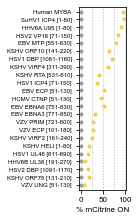

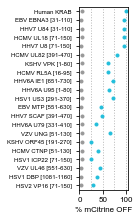

In [50]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

def plot_validation_summary(df, screentype):
    if screentype == 'Activation':
        reporter = 'DY032'
        color = '#F3CE48'
        meancol = 'Citrine ON'
        stdcol = 'ON std'
        xlabel = '% mCitrine ON'
        opposite = 'Repression'
        cutoff = 3e6
    elif screentype == 'Repression':
        reporter = 'JT039'
        color = '#23BEDB'
        meancol = 'Citrine OFF'
        stdcol = 'OFF std'
        xlabel = '% mCitrine OFF'
        opposite = 'Activation'
        cutoff = 1e7
    df =df[df['Duplicate']==0]
    df = df[(df['Screen']==screentype) & (~df[meancol].isna())].sort_values(by='Avg', ascending=False)
    df['Tile Start'] = np.where(df['Tile Start']=='', df['Tile Start'], df['Tile Start'].astype(str).str.split('.').str[0])
    df['Tile End'] = np.where(df['Tile End']=='', df['Tile End'], df['Tile End'].astype(str).str.split('.').str[0])
    df['Sample'] = np.where(df['Tile Start']=='', df['Virus Abbreviation'] + ' ' + df['Protein'],
                             df['Virus Abbreviation'] + ' ' + df['Protein'] + ' [' \
                             + df['Tile Start'] + '-' + df['Tile End'] + ']')
    
    samplelistD = list(df[df['Condition']=='dox']['Sample'])
    ticklistD = list(range(len(samplelistD)))
    meanlistD = list(df[df['Condition']=='dox'][meancol])
    stdlistD = list(df[df['Condition']=='dox'][stdcol])
    
    samplelistN = list(df[df['Condition']=='nodox']['Sample'])
    ticklistN = list(range(len(samplelistN)))
    meanlistN = list(df[df['Condition']=='nodox'][meancol])
    stdlistN = list(df[df['Condition']=='nodox'][stdcol])
    
#     samplelist = list(df['Sample'])
#     ticklist = list(range(len(samplelist)))
#     meanlist = list(df[meancol])
#     stdlist = list(df[stdcol])
    
    fig, ax = plt.subplots(figsize=(1.95, 3.1))
    
    for s, t, m, sd in zip(samplelistN, ticklistN, meanlistN, stdlistN):
        ax.plot(m, t, marker='o', markersize=3, color='#999999')
        ax.errorbar(x=m, y=t, xerr=sd, lw=1, color='#999999')
        
    for s, t, m, sd in zip(samplelistD, ticklistD, meanlistD, stdlistD):
        ax.plot(m, t, marker='o', markersize=3, color=color)
        ax.errorbar(x=m, y=t, xerr=sd, lw=1, color=color)
        
#     for s, t, m, sd in zip(samplelist, ticklist, meanlist, stdlist):
#         ax.plot(m, t, marker='o', markersize=3, color=color)
#         ax.errorbar(x=m, y=t, xerr=sd, lw=1, color=color)
        
    ax.set_xlabel(xlabel)
    ax.set_xticks(ticks=[0, 50, 100])
    for x in range(0, 101, 25):
        ax.axvline(x=x, ls=':', lw=1, color='#BBBBBB', zorder=-10)
    ax.set_yticks(ticks=ticklistD)
    ax.set_yticklabels(labels=samplelistD, fontsize=6)
    ax.set_ylim(ax.get_ylim()[0] + 0.5, ax.get_ylim()[1] - 0.5)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig('../Individual Figure Panels/Figure S3/vTR_%s_validation_summary2.png' % screentype, dpi=1200)
        
plot_validation_summary(keyA, 'Activation')
plot_validation_summary(keyR, 'Repression')
print('Complete')

### Dual activator-repressors

In [62]:
# read in dataframe and re-structure for plotting, etc.
df = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_ActivD2-ReprD5_detailed.csv')
dfA = df[df['Screen']=='Activation']
dfA = dfA[['Oligo ID', 'Avg', 'Net Charge', 'Duplicate', 'Tile Sequence']]
dfA = dfA.rename(columns={'Avg':'Activation'})
dfR = df[df['Screen']=='Repression']
dfR = dfR[['Oligo ID', 'Avg', 'Net Charge', 'Duplicate', 'Tile Sequence']]
dfR = dfR.rename(columns={'Avg':'Repression'})
df = pd.merge(left=dfA, right=dfR, on=['Oligo ID', 'Net Charge', 'Duplicate', 'Tile Sequence'], how='inner')
    
print('Complete')

Complete


#### Scatterplot featured in Fig. S3H highlighting a tile from EBV MTP

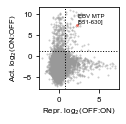

In [67]:
from adjustText import adjust_text

highlight = {'gHV_P03179_056':'EBV MTP\n[551-630]'}
df['Marker'] = df['Oligo ID'].map(highlight)

highlight_df = df[~df['Marker'].isna()]
xvals = list(highlight_df['Repression'])
yvals = list(highlight_df['Activation'])
labels = list(highlight_df['Marker'])

plt.figure(figsize=(1.79, 1.77))
sns.scatterplot(data=df[df['Duplicate']==0], y='Activation', x='Repression', color='#999999', linewidth=0, s=4, alpha=0.5)
sns.scatterplot(data=highlight_df, y='Activation', x='Repression', color='#EA7063', s=10)

plt.axhline(cutoffA_HHV, ls=':', lw=1, color='k')
plt.axvline(cutoffR_HHV, ls=':', lw=1, color='k')
plt.xlabel('Repr. log$_2$(OFF:ON)')
plt.ylabel('Act. log$_2$(ON:OFF)')
plt.tight_layout()

texts = []
for x, y, l in zip(xvals, yvals, labels):
    texts.append(plt.text(x, y, l, fontsize=6))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='#999999', lw=0), force_objects=(2, 2))

plt.savefig('../Individual Figure Panels/Figure S3/Act_vs_Rep_screen_scores_scatterplot_highlight_EBV-MTP.png', dpi=1200)

In [69]:
df1 = pd.read_csv('../Flow Single-Cell Data - CSV/HHV_validations_dual-Act-Rep_set-1_single-cell.csv')
df1 = df1.rename(columns={'Citrine-A':'mCitrine-A'})
df2 = pd.read_csv('../Flow Single-Cell Data - CSV/HHV_validations_dual-Act-Rep_set-2_single-cell.csv')
DF = pd.concat([df1, df2])
DF

,mCitrine-A,Condition,Construct,FSC 488/10-A,FSC 488/10-H,Protein,Replicate,Reporter,SSC 488/10-A,Time,mCherry-A,P1,P2,mCherry,Citrine
0,4.321566e+07,nodox,CL308,1.163360e+09,1.015024e+09,DBP,Rep2,JT039,406972928.0,0.0,1.504810e+08,True,True,True,True
1,2.919066e+07,nodox,CL308,1.277580e+09,1.053109e+09,DBP,Rep2,JT039,379673088.0,0.0,1.116096e+08,True,True,True,True
2,2.457594e+08,nodox,CL308,1.227754e+09,1.011246e+09,DBP,Rep2,JT039,399625728.0,0.0,1.723261e+08,True,True,True,True
3,6.702370e+07,nodox,CL308,1.000246e+09,8.321357e+08,DBP,Rep2,JT039,447561472.0,0.0,1.335468e+08,True,True,True,True
4,1.215271e+08,nodox,CL308,1.140471e+09,9.531727e+08,DBP,Rep2,JT039,420478208.0,0.0,1.602408e+08,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659995,1.785033e+07,dox,CL424,1.046276e+09,7.148485e+08,MTP,Rep1,JT039,329707008.0,5.0,7.658331e+07,True,True,True,True
659996,2.418041e+06,dox,CL424,1.134696e+09,7.334011e+08,MTP,Rep1,JT039,497466880.0,5.0,7.923920e+07,True,True,True,False
659997,1.698452e+07,dox,CL424,1.374986e+09,8.981361e+08,MTP,Rep1,JT039,530595328.0,5.0,1.733666e+08,True,True,True,True
659998,1.445541e+07,dox,CL424,1.088567e+09,7.344448e+08,MTP,Rep1,JT039,318508544.0,5.0,9.691189e+07,True,True,True,True


#### All validation flow cytometry distributions for a set of nine dual effector tiles (not featured in a panel)

<ipython-input-71-73fd486420df>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['Condition+Replicate'] = DF['Condition'] + '_' + DF['Replicate']
C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-71-73fd486420df>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['mCitrine'] = np.log10(DF['mCitrine-A'])
<ipython-input-71-73fd486420df>:22: SettingWi

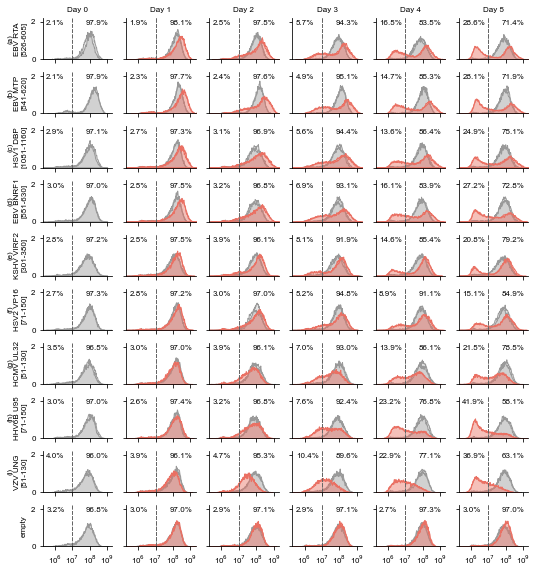

In [71]:
key = {'CL304':['HHV6B', 'U95', 71, 150, 7],
       'CL305':['HSV2', 'VP16', 71, 150, 5],
       'CL306':['EBV', 'BNRF1', 551, 630, 3],
       'CL308':['HSV1', 'DBP', 1081, 1160, 2],
       'CL313':['HCMV', 'UL32', 51, 130, 6],
       'CL336':['VZV', 'UNG', 51, 130, 8],
       'CL114':['EBV', 'RTA', 526, 605, 0],
       'CL424':['EBV', 'MTP', 541, 620, 1],
       'CL448':['KSHV', 'VIRF2', 301, 380, 4],
       'JT126':['', 'empty', '', '', 9]}

orderMap = {'0':'(a)\n', '1':'(b)\n', '2':'(c)\n', '3':'(d)\n', '4':'(e)\n', '5':'(f)\n', '6':'(g)\n', '7':'(h)\n', '8':'(i)\n', '9':'(j) '}

constr2virus = {k:key[k][0] for k in key}
constr2start = {k:str(key[k][2]) for k in key}
constr2end = {k:str(key[k][3]) for k in key}
constr2order = {k:str(key[k][4]) for k in key}

DF = DF[DF['mCherry']==True]
DF['Condition+Replicate'] = DF['Condition'] + '_' + DF['Replicate']
DF['mCitrine'] = np.log10(DF['mCitrine-A'])
DF['Virus'] = DF['Construct'].map(constr2virus)
DF['Start'] = DF['Construct'].map(constr2start)
DF['End'] = DF['Construct'].map(constr2end)
DF['Order'] = DF['Construct'].map(constr2order)
DF['Letter'] = DF['Order'].map(orderMap)
DF['Sample'] = np.where(DF['Construct']!='JT126', DF['Letter'] + DF['Virus'] + ' ' + DF['Protein'] + '\n[' + DF['Start'] + '-' + DF['End'] + ']',
                        'empty')
DF = DF.sort_values(by='Order')

labeldf = DF[(DF['Condition']=='dox') | (DF['Time']==0)]
labeldf = labeldf[['Sample', 'Construct', 'Time', 'Citrine', 'Order']]
labeldf = labeldf.groupby(by=['Sample', 'Construct', 'Time']).mean().reset_index()

OFF = list(labeldf['Citrine'])
OFF = [round(100*(1-off), 1)  for off in OFF]
ON = [str(round(100-off, 1)) + '%' for off in OFF]
OFF = [str(off) + '%' for off in OFF]
ylabels = list(labeldf['Sample'])

g = sns.FacetGrid(data=DF, row='Sample', col='Time', aspect=1.5625, height=0.8, hue='Condition+Replicate',
                  palette=sns.color_palette(['#999999', '#999999', '#EA7063', '#EA7063']))
g.map(sns.kdeplot, 'mCitrine', bw_adjust=0.1, fill=True, alpha=0.25, linewidth=1).set(xlim=(5.3, 9.3))
g.map(plt.axvline, x=np.log10(1e7), ls='--', color='#666666', lw=1)

for i, ax, on, off, ylab in zip(range(60), g.axes.flatten(), ON, OFF, ylabels):
    if i < 6:
        ax.set_title('Day %d' % i, fontsize=8)
    else:
        ax.set_title(label=None)
    if (i % 6 == 0):
        ax.set_ylabel(ylab)
    ax.text(0.05, 0.95, off, transform=ax.transAxes, ha='left', va='top')
    ax.text(0.95, 0.95, on, transform=ax.transAxes, ha='right', va='top')
    ax.set_ylim(0, 2.2)
        
# change x-tick marks to reflect log scale
plt.xticks([6, 7, 8, 9], ['10$^6$', '10$^7$', '10$^8$', '10$^9$'])
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S3/HHV_validations_dual-Act-Rep_facet.png', dpi=1200)

#### Timecourse for EBV MTP [551-630] featured in Fig. S3J

<ipython-input-116-8252c3491ab2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF2['Order'] = DF2.index


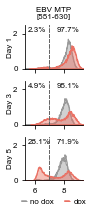

In [116]:
DF2 = DF[(DF['Construct']=='CL424') & (DF['Time'].isin([1, 3, 5]))]
DF2['Order'] = DF2.index
DF2 = DF2.sort_values(by='Order')
# print(DF2)

g = sns.FacetGrid(data=DF2, row='Time', aspect=1.3, height=1, hue='Condition+Replicate',
                  palette=sns.color_palette(['#999999', '#999999', '#EA7063', '#EA7063']))
g.map(sns.kdeplot, 'mCitrine', bw_adjust=0.1, fill=True, alpha=0.25, linewidth=1).set(xlim=(5.3, 9.3))
g.map(plt.axvline, x=np.log10(1e7), ls='--', color='#666666', lw=1)

labeldf = DF2[DF2['Condition']=='dox']
labeldf = labeldf[['Sample', 'Construct', 'Time', 'Citrine', 'Order']]
labeldf = labeldf.groupby(by=['Sample', 'Construct', 'Time']).mean().reset_index()

OFF = list(labeldf['Citrine'])
OFF = [round(100*(1-off), 1)  for off in OFF]
ON = [str(round(100-off, 1)) + '%' for off in OFF]
OFF = [str(off) + '%' for off in OFF]
ylabels = list(labeldf['Sample'])

for ax, on, off, day in zip(g.axes.flatten(), ON, OFF, [1, 3, 5]):
    ax.set_ylabel('Day %d' % day, fontsize=8, labelpad=0)
    ax.text(0.05, 0.95, off, transform=ax.transAxes, ha='left', va='top')
    ax.text(0.95, 0.95, on, transform=ax.transAxes, ha='right', va='top')
    ax.set_ylim(0, 2.5)
    if day == 1:
        ax.set_title('EBV MTP\n[551-630]', fontsize=8)
    else:
        ax.set_title('')
    
legend_elements = [Line2D([0], [0], marker='_', color='#999999', label='no dox'),
                   Line2D([0], [0], marker='_', color='#EA7063', label='dox')]
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.3), frameon=False,
           columnspacing=1.5, handlelength=0.5, borderpad=0.1, fontsize=8, handletextpad=0.5, ncol=2)
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S3/Dual_EBV_MTP_tile-056_day-1-3-5_timecourse_facet.png', dpi=1200)

### vTR vs HHV hits

#### Scatterplots featured in Fig. S3K & S3L

In [127]:
from scipy.stats import spearmanr
df_vTR = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR-CoV_ActivD2-ReprD5_detailed.csv')
df_HHV = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_ActivD2-ReprD5_detailed.csv')

def screen_corr(df1, df2, screenName1, screenName2, screenType):
    if screenType == 'Activation':
        ratio = 'ON:OFF'
        cutoff1 = cutoffA_vTR
        cutoff2 = cutoffA_HHV
        xticks = [-5, 0, 5, 10]
        xcoor = -7.5
        ycoor = 11
    elif screenType == 'Repression':
        ratio = 'OFF:ON'
        cutoff1 = cutoffR_vTR
        cutoff2 = cutoffR_HHV
        xticks = [-2, 0, 2, 4, 6]
        xcoor = 2.65
        ycoor = -0.8
    col_name1 = screenName1 + ' log$_2$(%s)' % ratio
    col_name2 = screenName2 + ' log$_2$(%s)' % ratio
    
    df1 = df1[df1['Screen']==screenType].rename(columns={'Avg':col_name1})
    df1 = df1[['Tile ID', col_name1]]
    df2 = df2[df2['Screen']==screenType].rename(columns={'Avg':col_name2})
    df2 = df2[['Tile ID', col_name2]]
    df = pd.merge(df1, df2, on='Tile ID', how='inner').drop_duplicates(subset=[col_name1, col_name2])
    
    x = np.array(list(df[col_name1]))
    y = np.array(list(df[col_name2]))
    coef, p = spearmanr(x, y)
    print(coef, p)
    
    plt.figure(figsize=(1.75, 1.9))
    sns.scatterplot(data=df, x=col_name1, y=col_name2, linewidth=0, s=4, alpha=0.5, color='#999999')
    plt.xticks(xticks)
    plt.axvline(x=cutoff1, color='k', ls=':', lw=1)
    plt.axhline(y=cutoff2, color='k', ls=':', lw=1)
    plt.annotate('r = ' + str(round(coef, 2)), xy=(xcoor, ycoor), ha='left', va='top')
    plt.title(screenType, fontsize=8)
    plt.tight_layout()
    plt.savefig('../Individual Figure Panels/Figure S3/%s-vs-%s_%s_tile_correlation.png' % (screenName1, screenName2, screenType), dpi=1200)
    plt.close()

screen_corr(df_vTR, df_HHV, 'vTR', 'HHV', 'Activation')
screen_corr(df_vTR, df_HHV, 'vTR', 'HHV', 'Repression')

print('Complete')


0.275318753020255 2.4353934586125243e-58
0.545135349242317 2.1952365846075725e-239
Complete


### HHV proteins that were hits in vTR only, both screens, or HHV only

#### Count total number of activation and repression domains and the number of proteins they come from (info related to Fig. 2E)

In [11]:
import pandas as pd
alldoms = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_domains.csv')
alldomsA = alldoms[alldoms['Effect']=='Activation']
alldomsR = alldoms[alldoms['Effect']=='Repression']

print('Total number of domains:', len(alldoms))
print('Total number of activation domains:', len(alldomsA))
print('Total number of repression domains:', len(alldomsR))
total_proteins = list(set(list(alldoms['Protein ID'])))
print('Total number of proteins with activation and/or repression domains:', len(total_proteins))

Total number of domains: 268
Total number of activation domains: 72
Total number of repression domains: 196
Total number of proteins with activation and/or repression domains: 178


#### Calculate numbers for Venn diagram in Fig. 2E (also in 'Viral Figure 2 + S3 (HHV tiling, notebook 1)')

In [12]:
# !{sys.executable} -m pip install matplotlib_venn
# this does NOT double count HHV6A/HHV6B domains of identical sequence
from matplotlib_venn import venn2

vTRprot = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/uniprot_vTR-census_wo-BSL4.csv')
vTRList = list(vTRprot['Entry'])

HHVprot = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_full-length-proteins_uID_sequence.csv')
HHVList = list(HHVprot['Cluster ID'])

shared = [i for i in vTRList if i in HHVList]
print(len(shared))
dom_vTR = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR_domains_estON-OFF.csv')
dom_HHV = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_domains_estON-OFF.csv')

vA = list(set(list(dom_vTR[dom_vTR['Effect']=='Activation']['Protein ID'])))
hA = list(set(list(dom_HHV[dom_HHV['Effect']=='Activation']['Protein ID'])))
vR = list(set(list(dom_vTR[dom_vTR['Effect']=='Repression']['Protein ID'])))
hR = list(set(list(dom_HHV[dom_HHV['Effect']=='Repression']['Protein ID'])))

dom_vTR2 = vA + vR
dom_vTR2 = list(set([v for v in dom_vTR2 if v in HHVList]))
dom_HHV2 = hA + hR
dom_HHV2 = list(set(dom_HHV2))
dom_vTR_HHV2 = list(set([v for v in dom_vTR2 if v in dom_HHV2]))
# nondom_vTR = list(set([v for v in dom_vTR if v not in dom_HHV]))
print(len(dom_HHV2)-len(dom_vTR_HHV2), len(dom_vTR2), len(dom_vTR_HHV2))


67
147 34 31


### Domain strengths of HHV proteins that were hits in both vTR/HHV (known) vs just HHV (new)

#### Swarmplots featured in Fig. S3M & S3N

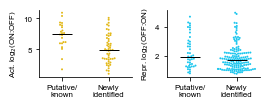

In [13]:
HHVdoms = dom_HHV.copy()
col_name = 'Effector Domain'
true_condition = 'Putative/\nknown'
false_condition = 'Newly\nidentified'
HHVdoms[col_name] = np.where(HHVdoms['Protein ID'].isin(dom_vTR_HHV2), true_condition, false_condition)
HHVdoms[col_name] = pd.Categorical(HHVdoms[col_name], categories=[true_condition, false_condition], ordered=True)
AY_med = np.median(list(HHVdoms[(HHVdoms['Effect']=='Activation') & (HHVdoms[col_name]==true_condition)]['Max Score']))
AN_med = np.median(list(HHVdoms[(HHVdoms['Effect']=='Activation') & (HHVdoms[col_name]==false_condition)]['Max Score']))
RY_med = np.median(list(HHVdoms[(HHVdoms['Effect']=='Repression') & (HHVdoms[col_name]==true_condition)]['Max Score']))
RN_med = np.median(list(HHVdoms[(HHVdoms['Effect']=='Repression') & (HHVdoms[col_name]==false_condition)]['Max Score']))

fig, ax = plt.subplots(1, 2, figsize=(3.75,1.45), gridspec_kw={'width_ratios':[1.6,1.6]})
sns.swarmplot(data=HHVdoms[HHVdoms['Effect']=='Activation'],
              x=col_name, y='Max Score', color='#E3B919', ax=ax[0], s=2) #, dodge=True)#, alpha=0.5)
ax[0].plot([0, 1], [AY_med, AN_med], 'k_', markersize=20, zorder=10)
ax[0].set_ylabel('Act. log$_2$(ON:OFF)')
ax[0].set_xlabel('')
sns.despine(ax=ax[0])

sns.swarmplot(data=HHVdoms[HHVdoms['Effect']=='Repression'],
              x=col_name, y='Max Score', color='#1BC6EE', ax=ax[1], s=2) #, dodge=True)#, alpha=0.5)
ax[1].plot([0, 1], [RY_med, RN_med], 'k_', markersize=20, zorder=10)
ax[1].set_ylabel('Repr. log$_2$(OFF:ON)')
ax[1].set_xlabel('')
sns.despine(ax=ax[1])
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S3/HHV-vTR_unique-vs-shared_hit_strength.png', dpi=1200)


### Strongest tile for all proteins (hits and non-hits) vs predicted NLS score (NucPred)

In [4]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = matplotlib.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [141]:
# for generating fasta file for NucPred
u90 = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/uniref_reviewed_HHV+SuHV.csv')
IDs = list(u90['Cluster ID'])
seqs = list(u90['Representative Sequence'])

with open('../Supplemental Tables - CSV/HHV-tiling/HHV_uniref90.fasta', 'w') as fasta:
    for i, s in zip(IDs, seqs):
        fasta.write('>' + i + '\n')
        fasta.write(s + '\n')
        
print('Complete')

Complete


#### Read in NucPred prediction and get strongest tile from each protein

In [16]:
NLS = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_uniref90_NucPred.csv')
NLS = NLS.rename(columns={'Sequence-ID':'Protein ID', 'NucPred-score':'NucPred'})

df = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_ActivD2-ReprD5_detailed.csv')
df = pd.merge(df, NLS, how='left', on='Protein ID')
df = df[~df['NucPred'].isna()]
dfA = df[df['Screen']=='Activation'].sort_values('Avg', ascending=False)
dfR = df[df['Screen']=='Repression'].sort_values('Avg', ascending=False)
dfA = dfA.drop_duplicates(subset='Protein ID', keep='first')
dfR = dfR.drop_duplicates(subset='Protein ID', keep='first')

colorA = get_continuous_cmap(['#BBBBBB', '#D7AC00'])
colorR = get_continuous_cmap(['#BBBBBB', '#23BEDB'])

#### Boxplot featured in Fig. S3Q

<ipython-input-17-7fec5418af93>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfA2['Group'] = np.where(dfA2['Avg']<=cutoffA_HHV, 'Non\nHit', 'Hit')
<ipython-input-17-7fec5418af93>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfA2cut['Group'] = pd.cut(dfA2cut['Avg'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])


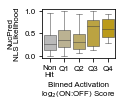

In [17]:
toexclude = list(set(list(dfR[dfR['Avg']>cutoffR_HHV]['Oligo ID'])))

dfA2 = dfA[~dfA['Oligo ID'].isin(toexclude)]
dfA2['Group'] = np.where(dfA2['Avg']<=cutoffA_HHV, 'Non\nHit', 'Hit')
dfA2cut = dfA2[dfA2['Group']=='Hit']
dfA2cut['Group'] = pd.cut(dfA2cut['Avg'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
dfA2 = pd.concat([dfA2[dfA2['Group']=='Non\nHit'], dfA2cut])
dfA2['Group'] = pd.Categorical(dfA2['Group'], categories=['Non\nHit', 'Q1', 'Q2', 'Q3', 'Q4'])

plt.figure(figsize=(1.8,1.5))
sns.boxplot(data=dfA2, x='Group', y='NucPred', linewidth=0.5, palette=colorA(np.linspace(0,1,5)), fliersize=1)
plt.ylabel('NucPred\nNLS Likelihood')
plt.xlabel('Binned Activation\nlog$_2$(ON:OFF) Score')
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S3/NLS_prediction_binned_Activation.png', dpi=1200)

#### Boxplot featured in Fig. S3R

<ipython-input-18-9a749d2281d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfR2['Group'] = np.where(dfR2['Avg']<=cutoffR_HHV, 'Non\nHit', 'Hit')
<ipython-input-18-9a749d2281d1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfR2cut['Group'] = pd.cut(dfR2cut['Avg'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])


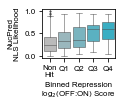

In [18]:
toexclude = list(set(list(dfA[dfA['Avg']>cutoffA_HHV]['Oligo ID'])))

dfR2 = dfR[~dfR['Oligo ID'].isin(toexclude)]
dfR2['Group'] = np.where(dfR2['Avg']<=cutoffR_HHV, 'Non\nHit', 'Hit')
dfR2cut = dfR2[dfR2['Group']=='Hit']
dfR2cut['Group'] = pd.cut(dfR2cut['Avg'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
dfR2 = pd.concat([dfR2[dfR2['Group']=='Non\nHit'], dfR2cut])
dfR2['Group'] = pd.Categorical(dfR2['Group'], categories=['Non\nHit', 'Q1', 'Q2', 'Q3', 'Q4'])

plt.figure(figsize=(1.8,1.5))
sns.boxplot(data=dfR2, x='Group', y='NucPred', linewidth=0.5, palette=colorR(np.linspace(0,1,5)), fliersize=1)
plt.ylabel('NucPred\nNLS Likelihood')
plt.xlabel('Binned Repression\nlog$_2$(OFF:ON) Score')
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S3/NLS_prediction_binned_Repression.png', dpi=1200)

### Inducible expression system featured in Fig. S3P

<ipython-input-256-a79a8d838700>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row_copy['Condition'] = 'dox'


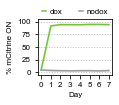

In [256]:
ies = pd.read_csv('../Flow Single-Cell Data - CSV/HTI_mCitrine_3Cpro_single-cell.csv')
ies = ies[(ies['Protein']=='mCitrine') & (ies['mCherry']==True)].sort_values(by=['Time', 'Condition'])
ies = ies.groupby(by=['Condition', 'Replicate', 'Time']).sum().reset_index().drop(columns=['Replicate'])
row_copy = ies.loc[(ies['Condition']=='nodox') & (ies['Time']==0)]
row_copy['Condition'] = 'dox'
ies = pd.concat([ies, row_copy]).reset_index(drop=True)
ies['% mCitrine ON'] = 100*ies['Citrine']/ies['mCherry']
plt.figure(figsize=(1.7,1.5))
sns.lineplot(data=ies, x='Time', y='% mCitrine ON', hue='Condition', palette=sns.color_palette(['#70C632', '#999999']))
plt.xticks(range(8))
plt.xlabel('Day')
plt.yticks(range(0, 101, 25))
plt.ylim(-5,105)
for y in list(range(0, 101, 25)):
    plt.axhline(y=y, ls=':', lw=1, zorder=-10, color='#BBBBBB')
plt.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.5, 1), handlelength=0.5, ncol=2,
           borderpad=0.1, handletextpad=0.5)
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S3/Inducible_expression_system_mCitrine_example.png', dpi=1200)

### END

In [86]:
vTRdom = pd.read_csv('Screen_Files/vTR-CoV/vTR_domains.csv')
print(len(vTRdom[vTRdom['Effect']=='Activation']))
print(len(vTRdom[vTRdom['Effect']=='Repression']))
print(len(vTRdom[vTRdom['Effect']=='Activation'].groupby('Protein ID')))
print(len(vTRdom[vTRdom['Effect']=='Repression'].groupby('Protein ID')))
print(len(vTRdom.groupby('Protein ID')))
virlist = ['SuHV1', 'CeHV1', 'CeHV2', 'HSV1', 'HSV2', 'VZV', 'HCMV', 'HHV6A', 'HHV6B', 'HHV7', 'EBV', 'KSHV']
print(len(vTRdom[vTRdom['Virus'].isin(virlist)].groupby('Protein ID')))

87
106
71
74
117
54
